In [1]:
cd ..

/Users/deepakduggirala/Documents/autonomous-robotics/bev-generation


In [2]:
import os
from pathlib import Path
import itertools
from io import BytesIO
import time
import json

import numpy as np
import scipy
import pandas as pd

import cv2

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.neighbors import KNeighborsClassifier

from nuscenes.nuscenes import NuScenes

import lmdb

from tqdm import tqdm

import utils
from utils import bytes_to_array
import nusc_utils

from bev_gt import generate_gt_bev_map, generate_gt_bev_360_maps_scene
from bev2 import BEV, generate_bev_seg_map

In [3]:
dataroot = Path('/Users/deepakduggirala/Documents/autonomous-robotics/v1.0-mini/').resolve()
nuscenes = NuScenes(version='v1.0-mini', dataroot=str(dataroot), verbose=False)

In [4]:
scene_idx = 0
sample_idx = 2

scene = nuscenes.scene[scene_idx]
sample = list(nusc_utils.sample_gen(nuscenes, scene))[sample_idx]
sample['token']

'356d81f38dd9473ba590f39e266f54e5'

In [5]:
nusc_idx_to_color = {
    0: (0, 207, 191),
    1: (175, 0, 75),
    2: (75, 0, 75),
    3: (112, 180, 60),
    4: (255, 158, 0),
    5: (255, 99, 71),
    6: (255, 69, 0),
    7: (255, 140, 0),
    8: (233, 150, 70),
    9: (138, 43, 226),
    10: (255, 61, 99),
    11: (220, 20, 60),
    12: (47, 79, 79),
    13: (112, 128, 144)
}
color_map_gt = {i + 1: c for i, c in nusc_idx_to_color.items()}
color_map_gt[0] = [255, 255, 255]  # color areas without any class as white
color_map_gt[2] = color_map_gt[1]  # color ped_crossing with same color as drivable_area
color_map_gt[4] = [255, 255, 255]  # do not color "carpark_area" - will be white

In [6]:
bev_gts = generate_gt_bev_360_maps_scene(nuscenes, scene)

/Users/deepakduggirala/miniforge3/envs/tim/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


(-0.5, 199.5, 399.5, -0.5)

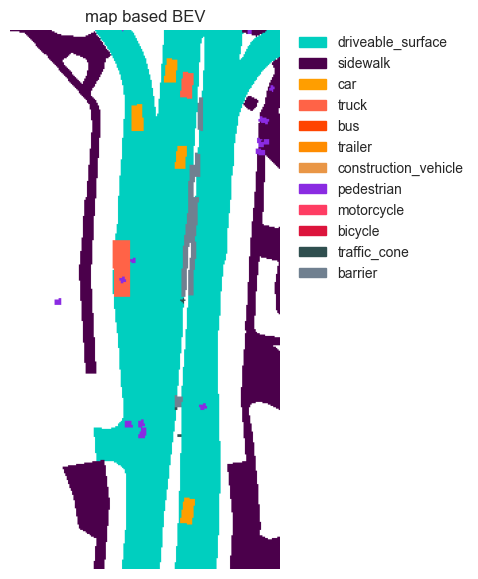

In [7]:
bev_gt = bev_gts[sample_idx]
bev_gt_map_cmp = utils.make_composite(bev_gt[:-1,:,:]) # do not apply visible (lidar + fov) mask
bev_gt_map_cmp_color = utils.color_components(bev_gt_map_cmp, color_map=color_map_gt)
fig, ax = plt.subplots(figsize=(15, 7))

ax.imshow(np.flip(bev_gt_map_cmp_color, 0))
ax.set_title('map based BEV')
ax.axis('off')

legend_colors = [np.append(np.array(nusc_idx_to_color[idx]) / 255, 1) for idx in range(len(nusc_idx_to_color))]
patches = [mpatches.Patch(color=legend_colors[i], label=label)
           for i, label in enumerate(nusc_utils.NUSC_LIDAR_CLASS_NAMES) if i not in [1, 3]]
ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.axis('off')

In [10]:
from collections import OrderedDict, namedtuple

import numpy as np

from shapely.strtree import STRtree
from nuscenes.nuscenes import NuScenes
from nuscenes.map_expansion.map_api import NuScenesMap

from shapely import geometry

In [11]:
Config = namedtuple('Config', ['map_extents', 'map_resolution'])
config = Config(map_extents=[-25., -50., 25., 50.], map_resolution=0.25)

In [12]:
def load_map_data(dataroot, location):
    # Load the NuScenes map object
    nusc_map = NuScenesMap(dataroot, location)

    map_data = OrderedDict()
    for layer in nusc_utils.STATIC_CLASSES:

        # Retrieve all data associated with the current layer
        records = getattr(nusc_map, layer)
        polygons = list()

        # Drivable area records can contain multiple polygons
        if layer == 'drivable_area':
            for record in records:

                # Convert each entry in the record into a shapely object
                for token in record['polygon_tokens']:
                    poly = nusc_map.extract_polygon(token)
                    if poly.is_valid:
                        polygons.append(poly)
        else:
            for record in records:

                # Convert each entry in the record into a shapely object
                poly = nusc_map.extract_polygon(record['polygon_token'])
                if poly.is_valid:
                    polygons.append(poly)

        # Store as an R-Tree for fast intersection queries
        map_data[layer] = STRtree(polygons)

    return map_data

In [15]:
# Preload NuScenes map data
map_data = {
    location: load_map_data(nuscenes.dataroot, location)
    for location in nusc_utils.LOCATIONS
}

In [16]:
map_data['boston-seaport']

OrderedDict([('drivable_area', <shapely.strtree.STRtree at 0x284ec62c0>),
             ('ped_crossing', <shapely.strtree.STRtree at 0x1680c3f70>),
             ('walkway', <shapely.strtree.STRtree at 0x1680c3f40>),
             ('carpark_area', <shapely.strtree.STRtree at 0x1680c37f0>)])

In [17]:
log = nuscenes.get('log', scene['log_token'])
log['location']

'singapore-onenorth'

In [18]:
scene_map_data = map_data[log['location']]
scene_map_data

OrderedDict([('drivable_area', <shapely.strtree.STRtree at 0x284c442e0>),
             ('ped_crossing', <shapely.strtree.STRtree at 0x284c46710>),
             ('walkway', <shapely.strtree.STRtree at 0x284c10970>),
             ('carpark_area', <shapely.strtree.STRtree at 0x284c10130>)])

In [19]:
lidar_data = nuscenes.get('sample_data', sample['data']['LIDAR_TOP'])
lidar_pcl = nusc_utils.load_point_cloud(nuscenes, lidar_data)

lidar_transform = nusc_utils.get_sensor_transform(nuscenes, lidar_data)
lidar_pcl = utils.transform(lidar_transform, lidar_pcl)

camera_data = nuscenes.get('sample_data', sample['data']['CAM_FRONT'])

In [20]:
tfm = nusc_utils.get_sensor_transform(nuscenes, camera_data)[[0, 1, 3]][:, [0, 2, 3]]
inv_tfm = np.linalg.inv(tfm)
inv_tfm

array([[-9.48211263e-01,  3.18267715e-01,  1.38966020e+01],
       [-3.17874344e-01, -9.48369887e-01,  1.23574668e+03],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])

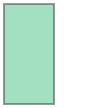

In [21]:
extents = config.map_extents
resolution = config.map_resolution

map_patch = geometry.box(*extents)
map_patch

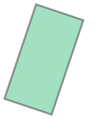

In [22]:
map_patch = utils.transform_polygon(map_patch, tfm)
map_patch

In [23]:
x1, z1, x2, z2 = extents
mask = np.zeros((int((z2 - z1) / resolution), int((x2 - x1) / resolution)),
                dtype=np.uint8)
mask.shape, mask.dtype

((400, 200), dtype('uint8'))

In [26]:
polygons = scene_map_data['ped_crossing']
len(polygons.geometries)

120

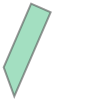

In [30]:
polygon = polygons.geometries.take(polygons.query(map_patch))[0]
polygon

In [31]:
p2 = polygon.intersection(map_patch)
p2

In [32]:
p3 = utils.transform_polygon(p2, inv_tfm)
p3

In [33]:
p3.geom_type

'Polygon'

In [34]:
p3_coords = p3.exterior.coords
p3_coords, len(p3_coords)

(<shapely.coords.CoordinateSequence at 0x1680e85b0>, 0)

array([-25.,   1.])

In [37]:
p3_coords_bev = (p3_coords - np.array(extents[:2])) / resolution
p3_coords_bev_int = np.ascontiguousarray(p3_coords_bev).round().astype(np.int32)
p3_coords_bev_int.shape, p3_coords_bev_int.dtype

((164, 2), dtype('int32'))

In [41]:
cv2.fillPoly(mask, [p3_coords_bev_int], 1)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]], dtype=uint8)

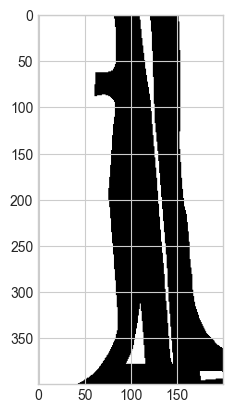

In [42]:
plt.imshow(mask)

In [43]:
np.array(p3.exterior.coords.xy).shape, np.array(p3.boundary.coords.xy).shape

((2, 164), (2, 164))

In [44]:
points = np.array([[x, y] for x, y in zip(*p3.exterior.coords.xy)])
points = (points - np.array(extents[:2]))/resolution
points = points.round().astype(np.int32) 
points.shape, points.dtype

((164, 2), dtype('int32'))

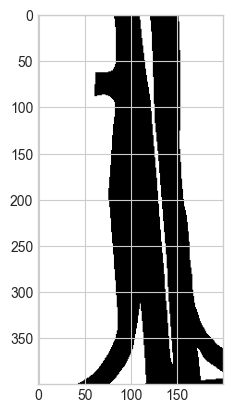

In [45]:
x1, z1, x2, z2 = extents
mask = np.zeros((int((z2 - z1) / resolution), int((x2 - x1) / resolution)),
                dtype=np.uint8)
mask = cv2.fillPoly(mask, [points], color=1)
plt.imshow(mask)

In [30]:
nusc_map.layer_names

['polygon',
 'line',
 'node',
 'drivable_area',
 'road_segment',
 'road_block',
 'lane',
 'ped_crossing',
 'walkway',
 'stop_line',
 'carpark_area',
 'lane_connector',
 'road_divider',
 'lane_divider',
 'traffic_light']

In [37]:
scene_map_data

OrderedDict([('drivable_area', <shapely.strtree.STRtree at 0x284c442e0>),
             ('ped_crossing', <shapely.strtree.STRtree at 0x284c46710>),
             ('walkway', <shapely.strtree.STRtree at 0x284c10970>),
             ('carpark_area', <shapely.strtree.STRtree at 0x284c10130>)])

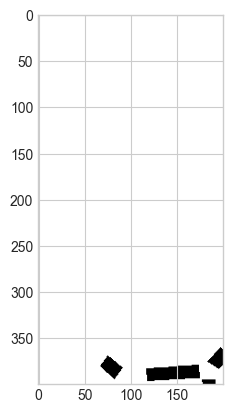

In [52]:
log = nuscenes.get('log', scene['log_token'])
scene_map_data = map_data[log['location']]
camera_data = nuscenes.get('sample_data', sample['data']['CAM_FRONT'])

layer = 'ped_crossing'
polygons = scene_map_data[layer]

layer_mask = nusc_utils.get_layer_mask(nuscenes, polygons, camera_data, extents, resolution)
plt.imshow(layer_mask)